Refered Code from :https://becominghuman.ai/melanoma-skin-cancer-detection-with-cnn-90dc3749f3d7

In [1]:
#Import some necessary Modules
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
#loading pictures 
def Dataset_loader(DIR,RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img)/255.)
    return IMG

benign_train = np.array(Dataset_loader('train/benign',224))
malign_train = np.array(Dataset_loader('train/malignant',224))
benign_test = np.array(Dataset_loader('test/benign',224))
malign_test = np.array(Dataset_loader('test/malignant',224))

100%|██████████| 300/300 [00:00<00:00, 384.07it/s]


In [3]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# Split validation data from train data
x_train=X_train[500:]
x_val=X_train[:500]
y_train=Y_train[500:]
y_val=Y_train[:500]

In [4]:
X_test.shape, x_val.shape, x_train.shape

((660, 224, 224, 3), (500, 224, 224, 3), (2137, 224, 224, 3))

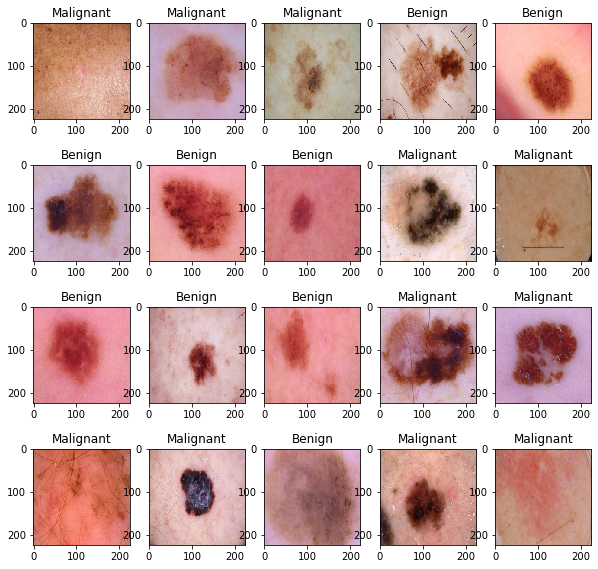

In [5]:
# Display first 20 images of moles

fig=plt.figure(figsize=(10, 10))

for i in range(1, 20 +1):
    ax = fig.add_subplot(4, 5, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [6]:
# one hot encoding 
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encodin
y_train = to_categorical(y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
y_val = to_categorical(y_val, num_classes= 2)

In [7]:
# normalization 
x_train = x_train/255.
X_test = X_test/255.
x_val = x_val/255.

In [8]:
X_test.shape, x_val.shape, x_train.shape

((660, 224, 224, 3), (500, 224, 224, 3), (2137, 224, 224, 3))

In [9]:
# data augmentation - cut out 

import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [10]:
# data augmentation 

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        preprocessing_function=get_random_eraser(p=0.5, v_h=0, s_h=0.25))

In [11]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

In [12]:
# building the model 

#!pip install -U efficientnet
# for tensorflow keras
#!pip install git+https://github.com/qubvel/classification_models.git#egg=classification_models
#from classification_models.tf.keras import Classifiers
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
#import efficientnet.keras as efn
from keras import regularizers 
#from keras import utils as np_utils



#eff_net = efn.EfficientNetB0(include_top=False, input_shape=(224, 224, 3))

#ResNet18, preprocess_input = Classifiers.get('resnet18')
#resnet = ResNet18((224, 224, 3), include_top=False)

#ResNeXt50, preprocess_input = Classifiers.get('resnext50')
resnet = ResNet50(include_top = False, input_shape=(224, 224, 3))

model=Sequential()
model.add(resnet)
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
#model.add_loss(lambda: penalty * tf.reduce_sum(tf.square(layer.trainable_variables[0])

alpha = 1e-3  # weight decay coefficient
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda:keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda:keras.regularizers.l2(alpha)(layer.bias))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 2

In [13]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [14]:

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=3)

In [15]:
# train the model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss="binary_crossentropy", metrics=['accuracy'])
#h = model.fit_generator(datagen.flow(x_train,y_train, batch_size=64),epochs=100, validation_data=[x_val, y_val],callbacks=[reduce_lr])
h = model.fit(x_train,y_train, batch_size=64,epochs=20, validation_data=(x_val, y_val),callbacks=[reduce_lr])

Epoch 1/20
34/34 [==============================] - 648s 19s/step - loss: 0.4835 - accuracy: 0.7843 - val_loss: 163.9717 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - 657s 19s/step - loss: 0.3810 - accuracy: 0.8339 - val_loss: 2.6612 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - 669s 20s/step - loss: 0.3371 - accuracy: 0.8489 - val_loss: 2.0714 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 4/20
34/34 [==============================] - 758s 22s/step - loss: 0.3012 - accuracy: 0.8676 - val_loss: 1.0580 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 5/20
34/34 [==============================] - 701s 21s/step - loss: 0.2917 - accuracy: 0.8760 - val_loss: 0.9269 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 6/20
34/34 [==============================] - 724s 21s/step - loss: 0.2669 - accuracy: 0.8896 - val_loss: 1.0552 - val_accuracy: 0.5300 - lr: 5.0000e-04
Epoch 7/20
34/34 [==============================] - 696s 20s/ste

Text(0.5, 1.0, 'Loss & Validation Loss')

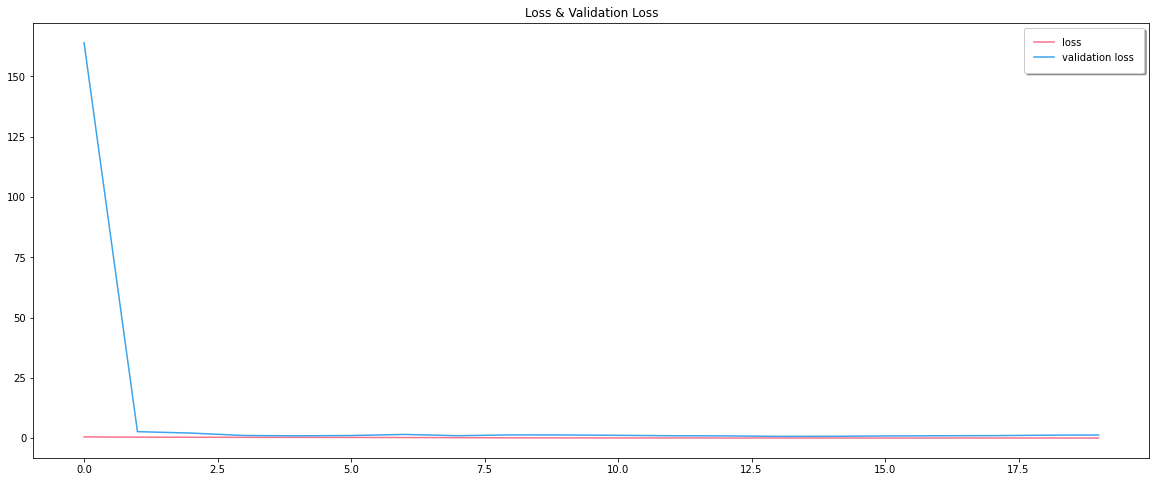

In [16]:
# loss and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(h.history['loss'],color="#F7728B", label='loss')
plt.plot(h.history['val_loss'], color="#3CA3EC", label='validation loss')
plt.legend(loc="upper right",fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.title(label="Loss & Validation Loss")

Text(0.5, 1.0, 'Accuracy & Validation Accuracy')

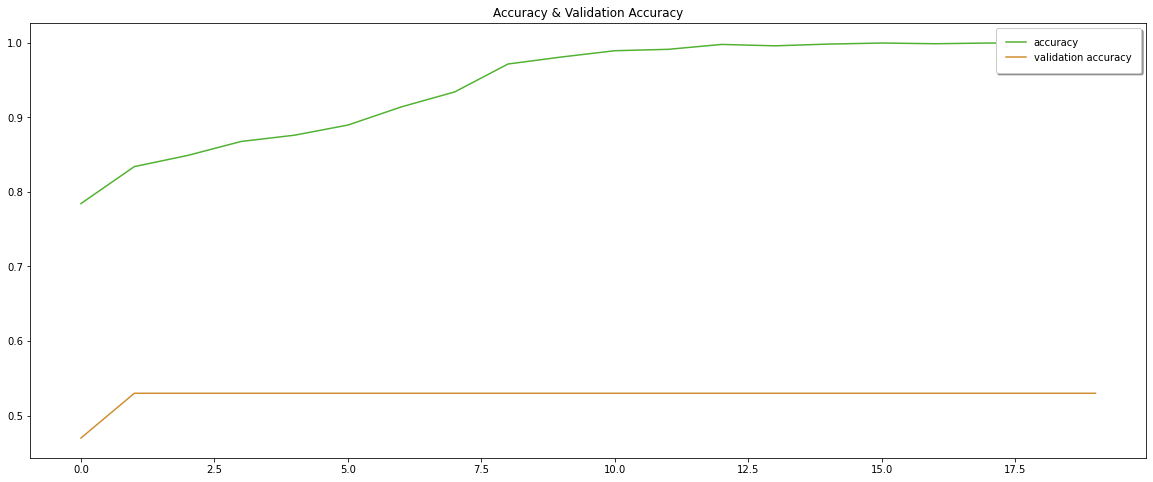

In [17]:
# accuracy and validation accuracy
plt.figure(figsize=(20,8))
plt.plot(h.history['accuracy'],color="#51B232", label='accuracy')
plt.plot(h.history['val_accuracy'], color="#CF8F32", label='validation accuracy')
plt.legend(loc="upper right",fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.title(label="Accuracy & Validation Accuracy")

In [18]:
# test the model 
results = model.evaluate(X_test, Y_test, batch_size=64)
print('test loss',results[0], 'test acc:',results[1])
results

11/11 [==============================] - 41s 4s/step - loss: 1.2182 - accuracy: 0.5455
test loss 1.2181923389434814 test acc: 0.5454545617103577


[1.2181923389434814, 0.5454545617103577]

In [19]:
# test the model
y_pred = model.predict(X_test, batch_size=64)
print(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

0.5454545454545454


In [25]:
#Confution Matrix

pred_results = np.where(y_pred>=0.5, 1,y_pred) 
pred_results2 = np.where(pred_results<0.5, 0,pred_results)

import sklearn
from sklearn.metrics import confusion_matrix
cm= sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1), pred_results2.argmax(axis=1))
print(cm)

[[360   0]
 [300   0]]
